<a href="https://colab.research.google.com/github/andremonroy/stanWeinstein/blob/main/Escoger_accionesFase_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🎯 SISTEMA DE ANÁLISIS STAN WEINSTEIN - OPORTUNIDADES ACTUALES
📋 Detectando tickers que están saliendo de Fase 1 hacia Fase 2
📊 Analizando 39 tickers

OPCIÓN 1: OPORTUNIDADES ACTUALES

🎯 BÚSQUEDA DE OPORTUNIDADES ACTUALES
Descargando datos históricos...
✓ Descargado SPY
✓ Descargado MEDP
✓ Descargado TBBK
✓ Descargado PODD
⚠️ HG: Datos insuficientes
⚠️ HNGE: Datos insuficientes
✓ Descargado AMSC
✓ Descargado KNSA
⚠️ ALAB: Datos insuficientes
✓ Descargado ALNT
✓ Descargado FNV
✓ Descargado PRM
⚠️ ARX: Datos insuficientes
✓ Descargado STX
✓ Descargado RMBS
✓ Descargado KGC
✓ Descargado URBN
✓ Descargado BAP
✓ Descargado EGO
✓ Descargado WDC
✓ Descargado HOOD
✓ Descargado APH
✓ Descargado RKLB
✓ Descargado EXTR
✓ Descargado NVDA
✓ Descargado TFPM
✓ Descargado ANET
✓ Descargado ATAT
✓ Descargado FIX
✓ Descargado OUST
✓ Descargado WGS
✓ Descargado LMND
⚠️ LIF: Datos insuficientes
⚠️ RDDT: Datos insuficientes
✓ Descargado ARQT
✓ Descargado TARS
✓ Descargado MIRM
✓ Descargado HSAI
✓ Descargado

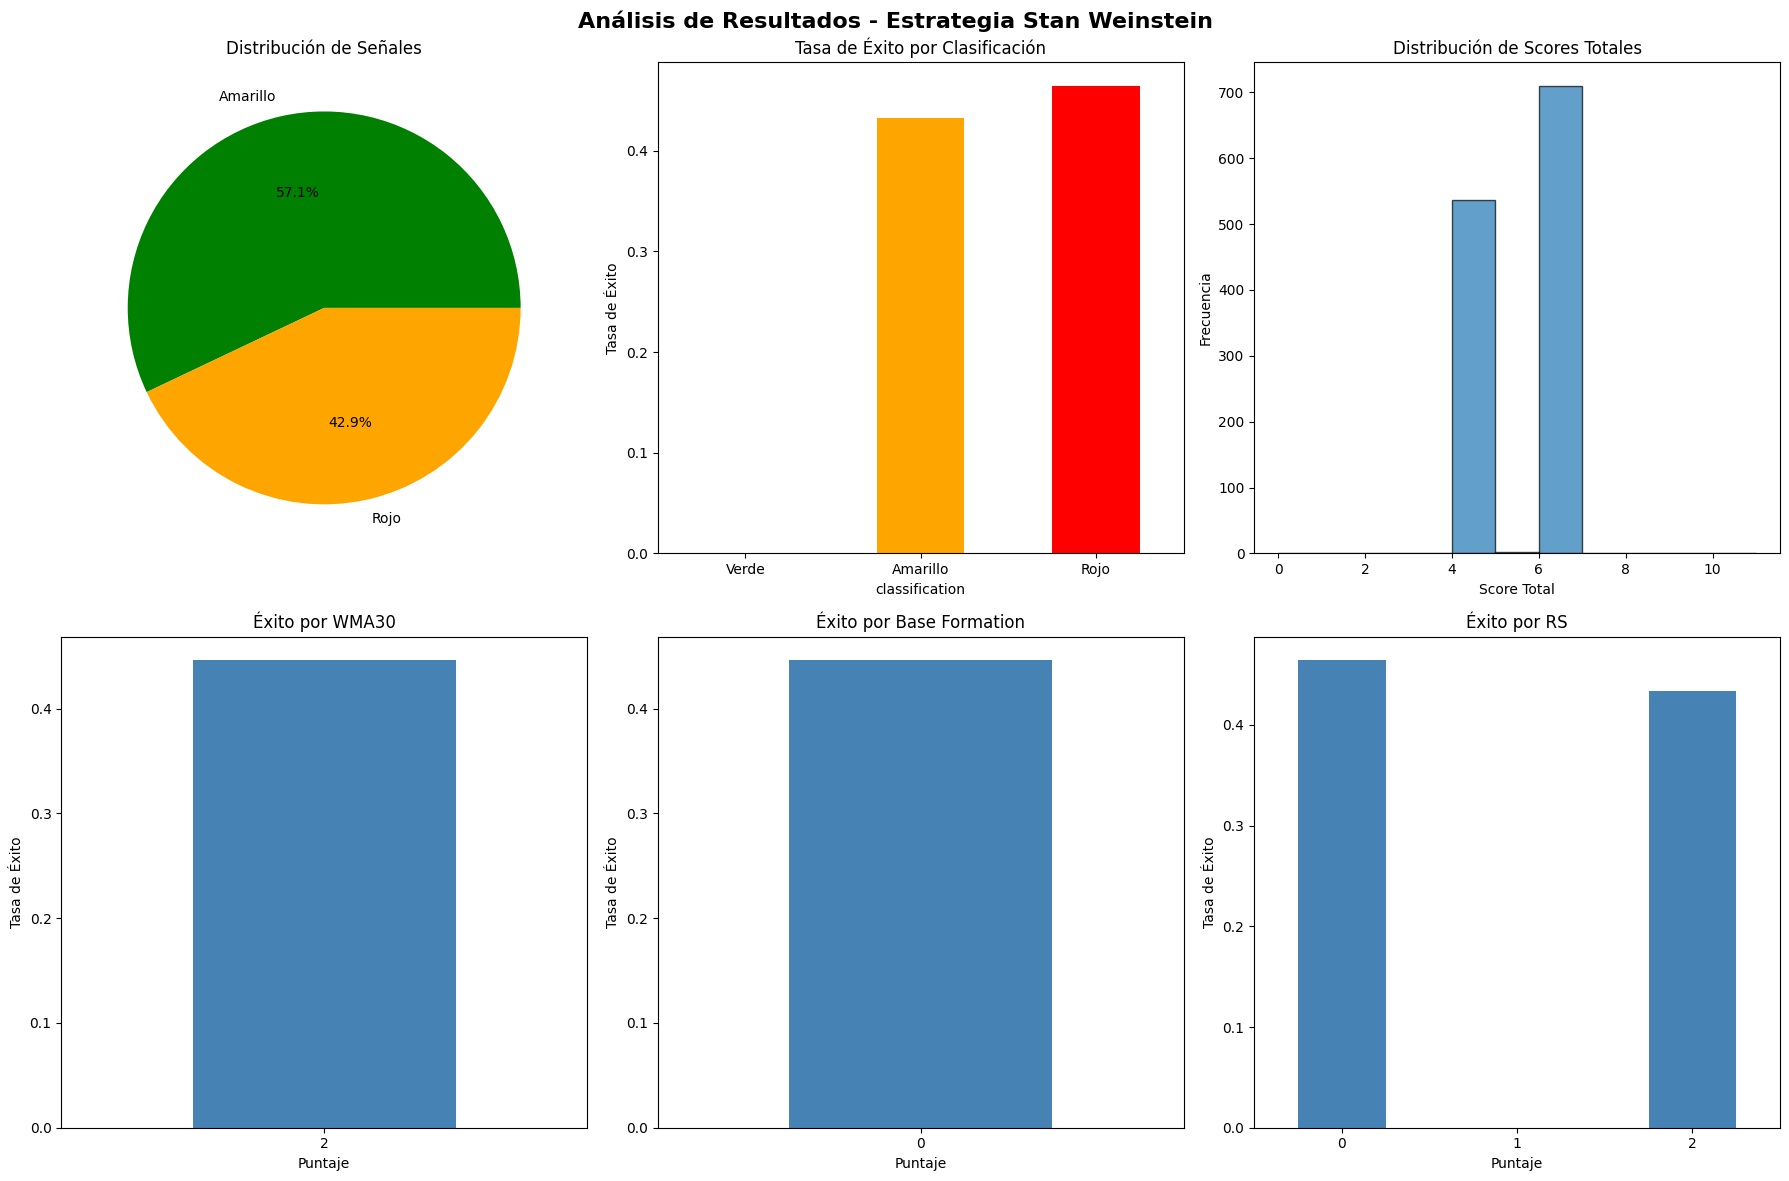

✅ Resultados exportados a: weinstein_backtest_results_20250830_150532.csv

💡 RECOMENDACIONES DE OPTIMIZACIÓN

WMA30:
  ✅ Criterio muy predictivo (diferencia: 44.6%)
  🎯 Mejor puntaje: 2 pts (44.6% éxito)

Base Formation:
  ✅ Criterio muy predictivo (diferencia: 44.6%)
  🎯 Mejor puntaje: 0 pts (44.6% éxito)

Relative Strength:
  ✅ Criterio muy predictivo (diferencia: 46.5%)
  🎯 Mejor puntaje: 0 pts (46.5% éxito)

Resistance:
  ✅ Criterio muy predictivo (diferencia: 44.6%)
  🎯 Mejor puntaje: 2 pts (44.6% éxito)

Volume:
  ✅ Criterio muy predictivo (diferencia: 44.6%)
  🎯 Mejor puntaje: 0 pts (44.6% éxito)

🎉 ¡Análisis completado!
📁 Revisa los archivos CSV generados
📈 Usa las oportunidades actuales para tu estrategia de trading

OPCIÓN 3: ANÁLISIS HISTÓRICO COMPLETO (OPCIONAL)
¿Deseas ejecutar también el análisis histórico completo?
(Esto toma más tiempo pero valida la estrategia en diferentes condiciones de mercado)


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, List, Tuple, Optional

# Ignorar advertencias para una salida más limpia, especialmente de pandas o yfinance
warnings.filterwarnings('ignore')

class WeinsteeinBacktest:
    """
    Sistema de backtesting para la estrategia de Stan Weinstein - Fase 1
    Detecta tickers que están por entrar en fase 2 (pre-breakout)

    Esta clase implementa la lógica para descargar datos, calcular indicadores
    según los criterios de Weinstein (WMA, base, fuerza relativa, resistencia, volumen),
    puntuar cada ticker en un momento dado, y realizar un backtest histórico o
    buscar oportunidades actuales.
    """

    def __init__(self, tickers: List[str], benchmark: str = "SPY", lookback_years: int = 10):
        """
        Inicializa el objeto WeinsteeinBacktest.

        Args:
            tickers (List[str]): Lista de símbolos de tickers a analizar.
            benchmark (str): Símbolo del benchmark (por defecto "SPY").
            lookback_years (int): Número de años hacia atrás para descargar datos (por defecto 10).
        """
        self.tickers = tickers
        self.benchmark = benchmark
        self.lookback_years = lookback_years
        self.data = {}  # Diccionario para almacenar los datos de los tickers
        self.benchmark_data = None  # Datos del benchmark
        self.results = []  # Lista para almacenar los resultados del backtest histórico
        self.analysis_results = {} # Diccionario para almacenar los resultados del análisis

    def download_data(self):
        """
        Descarga datos históricos semanales para todos los tickers y el benchmark
        utilizando la librería yfinance.

        Calcula la fecha de inicio basada en lookback_years.
        Verifica si se descargaron datos suficientes para cada ticker.

        Returns:
            bool: True si al menos un ticker y el benchmark se descargaron correctamente, False en caso contrario.
        """
        print("Descargando datos históricos...")

        # Calcular fecha de inicio basada en el número de años especificado
        end_date = datetime.now()
        start_date = end_date - timedelta(days=self.lookback_years * 365)

        # Descargar datos del benchmark
        try:
            # Descarga datos semanales ('1wk')
            benchmark_data = yf.download(self.benchmark, start=start_date, end=end_date, interval="1wk", progress=False)
            # Selecciona la columna 'Close' y elimina filas con valores faltantes
            self.benchmark_data = benchmark_data['Close'].dropna()
            print(f"✓ Descargado {self.benchmark}")
        except Exception as e:
            print(f"❌ Error descargando {self.benchmark}: {e}")
            return False # Si falla la descarga del benchmark, no se puede continuar

        # Descargar datos de los tickers individuales
        successful_downloads = 0
        for ticker in self.tickers:
            try:
                # Descarga datos semanales
                data = yf.download(ticker, start=start_date, end=end_date, interval="1wk", progress=False)
                # Verifica si hay suficientes datos (arbitrariamente > 100 semanas)
                if len(data) > 100:
                    self.data[ticker] = data # Almacena el DataFrame completo del ticker
                    successful_downloads += 1
                    print(f"✓ Descargado {ticker}")
                else:
                    # Si no hay suficientes datos, imprime una advertencia
                    print(f"⚠️ {ticker}: Datos insuficientes")
            except Exception as e:
                # Maneja errores individuales de descarga por ticker
                print(f"❌ Error descargando {ticker}: {e}")

        print(f"\nDescarga completada: {successful_downloads}/{len(self.tickers)} tickers exitosos")
        # Retorna True si al menos un ticker se descargó exitosamente (además del benchmark)
        return successful_downloads > 0

    def calculate_wma(self, prices: pd.Series, window: int = 30) -> pd.Series:
        """
        Calcula la Media Móvil Ponderada (WMA) para una serie de precios.

        La WMA da más peso a los precios recientes.
        Formula: (P_n * n + P_{n-1} * (n-1) + ... + P_1 * 1) / (n * (n+1) / 2)

        Args:
            prices (pd.Series): Serie de precios (típicamente el precio de cierre).
            window (int): Período de la WMA (número de semanas).

        Returns:
            pd.Series: Serie con los valores de la WMA. Retorna una serie vacía si no hay suficientes datos.
        """
        try:
            # Se necesitan al menos 'window' datos para calcular la primera WMA
            if len(prices) < window:
                return pd.Series(dtype=float)

            # Genera los pesos para la ponderación (1, 2, ..., window)
            weights = np.arange(1, window + 1)
            # Aplica la función de rolling para calcular la WMA
            wma = prices.rolling(window=window).apply(
                lambda x: np.dot(x, weights) / weights.sum(), raw=True
            )
            # Retorna la WMA, eliminando los valores NaN iniciales
            return wma.dropna()
        except:
            # En caso de cualquier error, retorna una serie vacía
            return pd.Series(dtype=float)

    def calculate_wma_slope(self, wma: pd.Series, periods: int = 3) -> float:
        """
        Calcula la pendiente de la WMA en porcentaje, comparando el valor actual
        con el valor 'periods' semanas atrás.

        Args:
            wma (pd.Series): Serie de la Media Móvil Ponderada.
            periods (int): Número de períodos hacia atrás para calcular la pendiente.

        Returns:
            float: Pendiente de la WMA en porcentaje. Retorna 0.0 si no hay suficientes datos o si hay errores.
        """
        try:
            # Se necesitan al menos 'periods + 1' puntos en la WMA para calcular la pendiente
            if len(wma) < periods + 1:
                return 0.0

            # Obtiene el último valor (actual) y el valor 'periods' semanas atrás
            current_wma = wma.iloc[-1]
            past_wma = wma.iloc[-periods-1]

            # Verifica si los valores son válidos y el valor pasado no es cero para evitar división por cero
            if pd.isna(current_wma) or pd.isna(past_wma) or past_wma == 0:
                return 0.0

            # Calcula la pendiente como cambio porcentual
            slope = (current_wma / past_wma - 1) * 100
            # Retorna la pendiente si no es NaN, de lo contrario retorna 0.0
            return slope if not pd.isna(slope) else 0.0
        except:
            # En caso de cualquier error, retorna 0.0
            return 0.0

    def calculate_relative_strength(self, stock_prices: pd.Series, benchmark_prices: pd.Series) -> Tuple[float, float]:
        """
        Calcula la Fuerza Relativa (RS) de un ticker frente a un benchmark.
        Retorna el valor actual del RS y la pendiente del RS.

        El RS se calcula como (precio_stock / precio_benchmark) * 100.
        La pendiente se calcula como el cambio porcentual del RS en las últimas 3 semanas.

        Args:
            stock_prices (pd.Series): Serie de precios del ticker.
            benchmark_prices (pd.Series): Serie de precios del benchmark.

        Returns:
            Tuple[float, float]: Una tupla con el valor actual de RS y la pendiente de RS.
                                 Retorna (100.0, 0.0) si no hay suficientes datos o si hay errores.
        """
        try:
            # Alinea las series de precios por fecha para asegurar que las comparaciones sean correctas
            aligned = pd.concat([stock_prices, benchmark_prices], axis=1, join='inner')
            # Si no hay suficientes datos alineados, retorna valores por defecto
            if aligned.empty or len(aligned) < 10:
                return 100.0, 0.0

            aligned.columns = ['stock', 'benchmark']
            aligned = aligned.dropna() # Elimina filas con valores faltantes después de alinear

            # Verifica si hay datos después de eliminar NaN y si el benchmark tiene precios no cero
            if aligned.empty or (aligned['benchmark'] == 0).any():
                return 100.0, 0.0

            # Calcular el ratio RS: (precio_stock / precio_benchmark) * 100
            rs_series = (aligned['stock'] / aligned['benchmark']) * 100

            # Si no hay suficientes puntos en la serie RS, retorna el último valor disponible o 100.0 y pendiente 0.0
            if len(rs_series) < 4:
                return rs_series.iloc[-1] if len(rs_series) > 0 else 100.0, 0.0

            # Calcula el valor actual de RS y el valor 3 semanas atrás para la pendiente
            current_rs = rs_series.iloc[-1]
            past_rs = rs_series.iloc[-4] # Se usa el valor de hace 3 semanas (índice -4)

            # Calcula la pendiente de RS como cambio porcentual
            rs_slope = (current_rs / past_rs - 1) * 100 if past_rs != 0 else 0.0

            # Retorna el valor actual de RS y su pendiente
            return current_rs, rs_slope
        except:
            # En caso de cualquier error, retorna valores por defecto
            return 100.0, 0.0

    def detect_base_formation(self, prices: pd.Series) -> Tuple[int, float]:
        """
        Detecta una formación de base (consolidación) en los precios recientes.
        Calcula la duración de la base (en semanas) y la volatilidad dentro de ella.

        Una "base" se define heurísticamente como un período reciente (últimas 20-40 semanas)
        donde el precio se mantiene dentro de un rango de poca volatilidad (menos del 20% de rango).

        Args:
            prices (pd.Series): Serie de precios de cierre.

        Returns:
            Tuple[int, float]: Una tupla con la duración de la base en semanas y la volatilidad anualizada (en %).
                               Retorna (0, 100.0) si no se detecta una base o hay errores.
        """
        try:
            # Se necesitan al menos 20 semanas de datos para intentar detectar una base
            if len(prices) < 20:
                return 0, 100.0

            # Calcular la volatilidad anualizada de los últimos retornos
            returns = prices.pct_change().dropna()
            if len(returns) == 0:
                return 0, 100.0

            # Volatilidad anualizada: desviación estándar de retornos diarios * raíz cuadrada de 52 (semanas en un año)
            volatility = returns.std() * np.sqrt(52) * 100
            # Si la volatilidad es NaN (por ejemplo, si solo hay un retorno válido), asigna un valor alto
            if pd.isna(volatility):
                volatility = 100.0

            # Detectar base heurísticamente: verificar si las últimas 20 semanas tienen un rango de precios bajo
            recent_prices = prices.tail(20)
            if len(recent_prices) == 0:
                return 0, volatility # No hay suficientes precios recientes

            # Calcular el rango de precios como (máximo - mínimo) / promedio en las últimas 20 semanas
            price_range = (recent_prices.max() - recent_prices.min()) / recent_prices.mean()

            # Si el rango de precios es bajo (heurística para base)
            if price_range < 0.20: # 20% de rango
                # Contar cuántas semanas hacia atrás el precio se mantuvo cerca del precio actual (dentro del 15%)
                current_price = prices.iloc[-1]
                base_weeks = 0

                # Buscar hacia atrás hasta un máximo de 40 semanas
                for i in range(len(prices)-1, max(0, len(prices)-40), -1):
                    # Calcular la diferencia porcentual con el precio actual
                    price_diff = abs(prices.iloc[i] - current_price) / current_price
                    if price_diff < 0.15: # Dentro de un rango del 15% del precio actual
                        base_weeks += 1
                    else:
                        # Si el precio sale del rango, la base termina aquí
                        break

                # Retorna la duración de la base en semanas y la volatilidad calculada previamente
                return base_weeks, volatility

            # Si el rango de precios reciente no es bajo, no se detecta una base
            return 0, volatility
        except:
            # En caso de cualquier error, retorna valores por defecto
            return 0, 100.0

    def find_resistance_level(self, prices: pd.Series, current_price: float) -> float:
        """
        Encuentra el nivel de resistencia más cercano por encima del precio actual.
        La resistencia se define como un máximo local significativo en el historial reciente.

        Busca máximos locales (picos) en las últimas 104 semanas (aproximadamente 2 años).
        Un máximo local se define como un punto más alto que las 2 semanas anteriores y las 2 semanas siguientes.

        Args:
            prices (pd.Series): Serie de precios de cierre.
            current_price (float): El precio de cierre actual.

        Returns:
            float: El nivel de resistencia más cercano por encima del precio actual.
                   Retorna un valor alto (current_price * 1.5) si no se encuentra resistencia.
        """
        try:
            # Se necesitan al menos 50 semanas de datos para buscar resistencias
            if len(prices) < 50:
                return current_price * 1.5 # Retorna un valor alto si no hay suficientes datos

            # Limita la búsqueda a las últimas 104 semanas (2 años)
            lookback_prices = prices.tail(min(104, len(prices)))

            highs = [] # Lista para almacenar los precios de los máximos locales encontrados
            # Itera a través de los precios para encontrar máximos locales
            # Se itera desde el índice 2 hasta el penúltimo - 2 para tener suficientes puntos a cada lado
            for i in range(2, len(lookback_prices)-2):
                # Condición para ser un máximo local: más alto que los 2 puntos anteriores y 2 siguientes
                if (lookback_prices.iloc[i] > lookback_prices.iloc[i-1] and
                    lookback_prices.iloc[i] > lookback_prices.iloc[i-2] and
                    lookback_prices.iloc[i] > lookback_prices.iloc[i+1] and
                    lookback_prices.iloc[i] > lookback_prices.iloc[i+2]):
                    # Solo considera máximos locales que estén al menos 2% por encima del precio actual
                    if lookback_prices.iloc[i] > current_price * 1.02:
                        highs.append(lookback_prices.iloc[i])

            # Retorna el mínimo de los máximos locales encontrados (el más cercano por encima)
            # Si no se encuentran máximos locales, retorna un valor alto por defecto
            return min(highs) if highs else current_price * 1.5
        except:
            # En caso de cualquier error, retorna un valor alto por defecto
            return current_price * 1.5

    def calculate_volume_pattern(self, volume: pd.Series) -> int:
        """
        Evalúa el patrón de volumen reciente (últimas 20 semanas).

        Asigna un puntaje basado en si el volumen es decreciente/estable (1),
        creciente hacia el final (2), o desordenado (0).

        Args:
            volume (pd.Series): Serie de volumen de trading.

        Returns:
            int: Puntaje del patrón de volumen (0, 1 o 2). Retorna 0 si no hay suficientes datos o hay errores.
        """
        try:
            # Se necesitan al menos 20 semanas de datos de volumen
            if len(volume) < 20:
                return 0

            # Toma el volumen de las últimas 20 semanas y elimina valores faltantes
            recent_vol = volume.tail(20).dropna()
            if len(recent_vol) < 10:
                return 0 # Se necesitan al menos 10 semanas de volumen válido

            # Divide las últimas 20 semanas en dos mitades y calcula el volumen promedio
            vol_first_half = recent_vol.head(10).mean()
            vol_second_half = recent_vol.tail(10).mean()
            # Calcula el coeficiente de variación del volumen reciente (std / mean)
            vol_cv = recent_vol.std() / recent_vol.mean()

            # Verifica si los valores calculados son válidos
            if pd.isna(vol_first_half) or pd.isna(vol_second_half) or pd.isna(vol_cv):
                return 0

            # Patrón de volumen decreciente y estable (baja volatilidad en volumen)
            if vol_second_half < vol_first_half * 0.8 and vol_cv < 0.5:
                return 1 # Puntaje 1

            # Patrón de volumen aumentando significativamente en el último cuarto (últimas 5 semanas)
            vol_last_quarter = recent_vol.tail(5).mean()
            if vol_last_quarter > vol_first_half * 1.2:
                return 2 # Puntaje 2 (indica interés creciente)

            # Cualquier otro patrón se considera desordenado
            return 0
        except:
            # En caso de cualquier error, retorna 0
            return 0

    def calculate_scores(self, ticker: str, date: pd.Timestamp) -> Optional[Dict]:
        """
        Calcula el puntaje para un ticker en una fecha específica basándose en
        los criterios de Stan Weinstein.

        Combina los puntajes individuales de WMA, Base, RS, Resistencia y Volumen
        para obtener un puntaje total y una clasificación (Verde, Amarillo, Rojo).

        Args:
            ticker (str): Símbolo del ticker.
            date (pd.Timestamp): Fecha para la cual calcular los puntajes.

        Returns:
            Optional[Dict]: Un diccionario con los puntajes y detalles del análisis para la fecha dada,
                            o None si no hay suficientes datos o hay errores.
        """
        try:
            stock_data = self.data[ticker]
            # Filtra los datos hasta la fecha especificada (inclusive)
            data_until_date = stock_data[stock_data.index <= date]

            # Se necesitan al menos 50 semanas de datos históricos hasta la fecha
            if len(data_until_date) < 50:
                return None

            # Extrae las series de precios de cierre y volumen hasta la fecha
            prices = data_until_date['Close'].dropna()
            volume = data_until_date['Volume'].dropna()

            # Se necesitan al menos 30 semanas de precios válidos para calcular la WMA30
            if len(prices) < 30:
                return None

            # Obtiene el precio de cierre actual
            current_price = float(prices.iloc[-1])
            if current_price <= 0:
                return None # No se puede analizar con precio cero o negativo

            # 1. Puntaje de WMA30 y Pendiente
            wma30 = self.calculate_wma(prices, 30)
            # Solo calcula la pendiente si hay suficientes puntos en la WMA30
            wma_slope = self.calculate_wma_slope(wma30, 3) if len(wma30) > 3 else 0.0

            # Asigna el puntaje según la pendiente de la WMA30
            if wma_slope < -0.1:
                wma_score = 0
            elif -0.1 <= wma_slope <= 0.1:
                wma_score = 2 # Plana o ligeramente ascendente/descendente
            else:
                wma_score = 1 # Ascendente

            # 2. Puntaje de Formación de Base
            base_weeks, base_volatility = self.detect_base_formation(prices)

            # Asigna el puntaje según la duración de la base y la volatilidad
            if base_weeks < 5:
                base_score = 0
            elif 5 <= base_weeks <= 15:
                base_score = 1
            elif base_weeks >= 15 and base_volatility < 10: # Base larga y de baja volatilidad
                base_score = 2
            else:
                base_score = 0 # Base larga pero con volatilidad

            # 3. Puntaje de Fuerza Relativa (RS)
            # Filtra los datos del benchmark hasta la fecha
            benchmark_until_date = self.benchmark_data[self.benchmark_data.index <= date]
            current_rs, rs_slope = self.calculate_relative_strength(prices, benchmark_until_date)

            # Asigna el puntaje según el valor de RS y su pendiente
            if rs_slope < 0:
                rs_score = 0 # RS decreciendo
            elif current_rs < 100 and rs_slope > 0:
                rs_score = 2 # RS bajo pero mejorando
            elif current_rs > 100 and rs_slope > 0:
                rs_score = 1 # RS alto y mejorando
            else:
                rs_score = 0 # RS plano o en descenso

            # 4. Puntaje de Resistencia
            resistance = self.find_resistance_level(prices, current_price)
            # Calcula la distancia porcentual a la resistencia
            resistance_distance = (resistance / current_price - 1) * 100

            # Asigna el puntaje según la distancia a la resistencia
            if resistance_distance < 10:
                resistance_score = 0 # Resistencia muy cercana
            elif 10 <= resistance_distance <= 20:
                resistance_score = 1 # Resistencia a distancia moderada
            else:
                resistance_score = 2 # Resistencia lejana o no encontrada (potencial de subida)

            # 5. Puntaje de Volumen
            volume_score = self.calculate_volume_pattern(volume)

            # Calcular el puntaje total sumando los puntajes individuales
            total_score = wma_score + base_score + rs_score + resistance_score + volume_score

            # Clasificación final basada en el puntaje total
            if total_score >= 8:
                classification = "Verde" # Muy buena señal
            elif total_score >= 5:
                classification = "Amarillo" # Señal interesante, requiere confirmación
            else:
                classification = "Rojo" # Señal débil o ausente

            # Retorna un diccionario con todos los detalles y puntajes calculados
            return {
                'ticker': ticker,
                'date': date,
                'price': current_price,
                'wma30': float(wma30.iloc[-1]) if len(wma30) > 0 else None,
                'wma_slope': wma_slope,
                'base_weeks': base_weeks,
                'base_volatility': base_volatility,
                'rs_value': current_rs,
                'rs_slope': rs_slope,
                'resistance_distance': resistance_distance,
                'wma_score': wma_score,
                'base_score': base_score,
                'rs_score': rs_score,
                'resistance_score': resistance_score,
                'volume_score': volume_score,
                'total_score': total_score,
                'classification': classification
            }

        except Exception as e:
            # Si ocurre un error durante el cálculo de puntajes para un ticker/fecha, retorna None
            # Opcionalmente, imprimir detalles del error si el modo debug está activado
            if hasattr(self, 'debug_mode') and self.debug_mode:
                print(f"Error detallado en {ticker} - {date}: {str(e)}")
            return None

    def check_breakout(self, ticker: str, signal_date: pd.Timestamp, weeks_ahead: int = 8, threshold: float = 15.0) -> bool:
        """
        Verifica si ocurrió un breakout (ruptura significativa al alza) después de una fecha de señal.

        Busca si el precio alcanza o supera un umbral porcentual ('threshold')
        dentro de un número específico de semanas ('weeks_ahead') posteriores a la fecha de la señal.

        Args:
            ticker (str): Símbolo del ticker.
            signal_date (pd.Timestamp): Fecha en la que se generó una señal.
            weeks_ahead (int): Número de semanas hacia adelante para buscar el breakout (por defecto 8).
            threshold (float): Umbral de breakout en porcentaje (por defecto 15.0, es decir, un 15% de subida).

        Returns:
            bool: True si ocurrió un breakout dentro del período especificado, False en caso contrario.
        """
        try:
            stock_data = self.data[ticker]
            # Obtiene los precios de cierre hasta la fecha de la señal para obtener el precio de la señal
            signal_price_data = stock_data[stock_data.index <= signal_date]['Close']

            # Si no hay datos hasta la fecha de la señal, no se puede verificar el breakout
            if signal_price_data.empty:
                return False

            # Obtiene el precio de cierre en la fecha de la señal
            signal_price = float(signal_price_data.iloc[-1])
            if signal_price <= 0:
                return False # No se puede calcular el breakout con precio cero o negativo

            # Obtiene los datos de precios en las semanas posteriores a la señal
            future_data = stock_data[stock_data.index > signal_date]['Close'].head(weeks_ahead)
            if future_data.empty:
                return False # No hay datos futuros para verificar el breakout

            # Encuentra el precio máximo alcanzado en el período futuro
            max_future_price = float(future_data.max())
            # Verifica si el precio máximo supera el umbral de breakout
            return (max_future_price / signal_price - 1) * 100 >= threshold

        except:
            # En caso de cualquier error, retorna False
            return False

    def run_backtest(self, debug_mode: bool = False, focus_recent: bool = True):
        """
        Ejecuta el backtest completo de la estrategia Stan Weinstein.

        Itera a través de los tickers y fechas (semanales) para calcular los puntajes
        y verificar si ocurrió un breakout posterior. Almacena los resultados.

        Args:
            debug_mode (bool): Si True, imprime información de debug durante la ejecución.
            focus_recent (bool): Si True, enfoca el análisis en los últimos 18 meses.
                                 Si False, realiza un backtest histórico completo (más lento).

        Returns:
            bool: True si se procesaron señales, False si hubo un error en la descarga de datos.
        """
        # Configura el modo debug
        self.debug_mode = debug_mode
        print("\n🚀 Iniciando backtest de estrategia Stan Weinstein...")

        # Descarga los datos necesarios
        if not self.download_data():
            print("❌ Error en descarga de datos")
            return False # Si falla la descarga, sale de la función

        print("\n📊 Calculando señales...")

        total_signals = 0 # Contador de señales procesadas en total
        processed_tickers = 0 # Contador de tickers procesados

        # Determina qué tickers procesar: todos o solo los primeros 5 en modo debug
        tickers_to_process = list(self.data.keys())[:5] if debug_mode else list(self.data.keys())

        # Itera a través de los tickers seleccionados
        for ticker in tickers_to_process:
            try:
                stock_data = self.data[ticker]
                ticker_signals = 0 # Contador de señales procesadas para el ticker actual

                if debug_mode:
                    print(f"\n🔍 DEBUG - {ticker}: {len(stock_data)} semanas de datos")
                    print(f"   Rango: {stock_data.index[0].strftime('%Y-%m-%d')} a {stock_data.index[-1].strftime('%Y-%m-%d')}")

                # Determina los puntos de evaluación (fechas)
                if focus_recent:
                    # Si focus_recent es True, enfócate en los últimos ~18 meses para la evaluación
                    # Necesitamos datos suficientes antes de la fecha de evaluación para los indicadores
                    # Empezamos a evaluar desde al menos 50 semanas antes del final, o desde el inicio si son menos datos
                    recent_evaluation_start_pos = max(50, len(stock_data) - int(1.5 * 52)) # 1.5 años * 52 semanas/año
                    # Evaluar cada 2 semanas para mayor eficiencia en el análisis reciente
                    evaluation_points_indices = range(recent_evaluation_start_pos, len(stock_data), 2)
                else:
                    # Análisis histórico completo, evalúa cada 4 semanas (o cada 8 en debug)
                    # Empezar desde al menos 50 semanas para tener datos para indicadores
                    evaluation_points_indices = range(50, len(stock_data), 8 if debug_mode else 4)

                # Itera a través de los índices de las fechas de evaluación
                for i in evaluation_points_indices:
                    if i >= len(stock_data):
                        continue # Asegura que el índice no exceda el tamaño del DataFrame

                    date = stock_data.index[i] # Obtiene la fecha correspondiente al índice

                    # Si focus_recent es True, salta las fechas anteriores a los últimos ~18 meses
                    if focus_recent:
                        recent_cutoff = datetime.now() - timedelta(days=int(1.5 * 365)) # 1.5 años
                        if date.to_pydatetime() < recent_cutoff:
                            continue

                    # Calcula los puntajes para el ticker en la fecha actual
                    scores = self.calculate_scores(ticker, date)

                    if scores:
                        # Si se pudieron calcular los puntajes, verifica si hubo un breakout posterior
                        breakout = self.check_breakout(ticker, date)
                        scores['breakout_occurred'] = breakout # Añade el resultado del breakout al diccionario de scores

                        self.results.append(scores) # Almacena los resultados en la lista principal
                        total_signals += 1 # Incrementa el contador total de señales
                        ticker_signals += 1 # Incrementa el contador de señales para el ticker actual

                        # Imprime detalles de la señal en modo debug
                        if debug_mode and ticker_signals <= 5:
                            print(f"   ✅ {date.strftime('%Y-%m-%d')}: {scores['classification']} (Score: {scores['total_score']})")

                    # En modo debug, limita el número de señales por ticker para una ejecución más rápida
                    if debug_mode and ticker_signals >= 8 and focus_recent: # Límite más alto en debug para análisis reciente
                        break
                    elif debug_mode and ticker_signals >= 5 and not focus_recent: # Límite más bajo en debug para análisis histórico
                         break


                processed_tickers += 1 # Incrementa el contador de tickers procesados
                # Imprime el estado del procesamiento del ticker (✓ si hubo señales, ⚠️ si no)
                status = "✓" if ticker_signals > 0 else "⚠️"
                print(f"{status} {ticker}: {ticker_signals} señales procesadas")

            except Exception as e:
                # Maneja errores durante el procesamiento de un ticker
                print(f"❌ Error procesando {ticker}: {str(e)}")
                continue # Continúa con el siguiente ticker

        print(f"\n✅ Backtest completado:")
        print(f"   • Tickers procesados: {processed_tickers}")
        print(f"   • Total señales: {total_signals}")

        # Retorna True si se procesó al menos una señal
        return total_signals > 0

    def analyze_results(self):
        """
        Analiza los resultados del backtest histórico.

        Calcula la distribución de clasificaciones (Verde, Amarillo, Rojo),
        la tasa de éxito de breakout para cada clasificación, y
        la tasa de éxito por puntaje para cada criterio individual.

        Almacena los resultados del análisis en self.analysis_results.

        Returns:
            pd.DataFrame: Un DataFrame con los resultados completos del backtest.
                          Retorna None si no hay resultados para analizar.
        """
        # Verifica si hay resultados para analizar
        if not self.results:
            print("❌ No hay resultados para analizar")
            return None

        # Convierte la lista de resultados a un DataFrame de pandas
        df = pd.DataFrame(self.results)

        print("\n📈 RESULTADOS DEL BACKTEST")
        print("=" * 50)

        # Calcula la distribución de clasificaciones
        total_signals = len(df)
        verde_signals = len(df[df['classification'] == 'Verde'])
        amarillo_signals = len(df[df['classification'] == 'Amarillo'])
        rojo_signals = len(df[df['classification'] == 'Rojo'])

        print(f"Total de señales evaluadas: {total_signals}")
        print(f"Señales Verdes: {verde_signals} ({verde_signals/total_signals*100:.1f}%)")
        print(f"Señales Amarillas: {amarillo_signals} ({amarillo_signals/total_signals*100:.1f}%)")
        print(f"Señales Rojas: {rojo_signals} ({rojo_signals/total_signals*100:.1f}%)")

        print(f"\n🎯 TASA DE ÉXITO DE BREAKOUT")
        print("-" * 30)

        # Calcula la tasa de éxito de breakout para cada clasificación
        for classification in ['Verde', 'Amarillo', 'Rojo']:
            class_df = df[df['classification'] == classification]
            if len(class_df) > 0:
                # La columna 'breakout_occurred' es booleana (True/False)
                # La media de una columna booleana es la proporción de True (tasa de éxito)
                success_rate = class_df['breakout_occurred'].mean() * 100
                successes = class_df['breakout_occurred'].sum() # Suma de True (número de breakouts)
                total = len(class_df) # Número total de señales en esta clasificación
                print(f"{classification}: {success_rate:.1f}% ({successes}/{total})")

        print(f"\n🔍 ANÁLISIS POR CRITERIO")
        print("-" * 30)

        # Define los criterios individuales a analizar
        criteria = ['wma_score', 'base_score', 'rs_score', 'resistance_score', 'volume_score']
        criteria_names = ['WMA30', 'Base Formation', 'Relative Strength', 'Resistance', 'Volume']

        # Almacena los resultados del análisis por criterio
        self.analysis_results['criteria_analysis'] = {}

        # Analiza la tasa de éxito por puntaje para cada criterio
        for criterion, name in zip(criteria, criteria_names):
            print(f"\n{name}:")
            criterion_analysis = {}

            # Itera sobre los posibles puntajes de cada criterio (0, 1, 2)
            for score in [0, 1, 2]:
                # Filtra el DataFrame para el criterio y puntaje actuales
                score_df = df[df[criterion] == score]
                if len(score_df) > 0:
                    # Calcula la tasa de éxito de breakout para este puntaje
                    success_rate = score_df['breakout_occurred'].mean() * 100
                    count = len(score_df) # Número de señales con este puntaje
                    breakouts = score_df['breakout_occurred'].sum() # Número de breakouts con este puntaje
                    print(f"  {score} pts: {success_rate:.1f}% ({breakouts}/{count})")
                    # Almacena los resultados en el diccionario de análisis
                    criterion_analysis[score] = {
                        'success_rate': success_rate,
                        'count': count,
                        'breakouts': breakouts
                    }
                else:
                    # Si no hay señales con este puntaje, registra 0
                    criterion_analysis[score] = {'success_rate': 0, 'count': 0, 'breakouts': 0}

            # Almacena los resultados del análisis del criterio actual
            self.analysis_results['criteria_analysis'][name] = criterion_analysis

        # Almacena el DataFrame completo de resultados en el diccionario de análisis
        self.analysis_results['full_results'] = df
        # Retorna el DataFrame completo de resultados
        return df

    def plot_results(self):
        """
        Genera y muestra gráficos visuales de los resultados del backtest.

        Incluye gráficos de distribución de señales, tasa de éxito por clasificación
        y tasa de éxito por puntaje para los criterios principales.
        """
        # Verifica si hay resultados completos para graficar
        if 'full_results' not in self.analysis_results:
            print("❌ No hay resultados para graficar")
            return

        df = self.analysis_results['full_results']

        # Configura el estilo de los gráficos
        plt.style.use('default')
        # Crea una figura con una cuadrícula de subgráficos (2 filas, 3 columnas)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        # Añade un título principal a la figura
        fig.suptitle('Análisis de Resultados - Estrategia Stan Weinstein', fontsize=16, fontweight='bold')

        # 1. Gráfico de Distribución de clasificaciones (Pie Chart)
        class_counts = df['classification'].value_counts()
        colors = ['green', 'orange', 'red'] # Define colores para cada clasificación
        axes[0,0].pie(class_counts.values, labels=class_counts.index, colors=colors, autopct='%1.1f%%')
        axes[0,0].set_title('Distribución de Señales') # Título del subgráfico

        # 2. Gráfico de Tasa de éxito por clasificación (Bar Chart)
        # Agrupa por clasificación y calcula la media de 'breakout_occurred' (tasa de éxito)
        success_by_class = df.groupby('classification')['breakout_occurred'].agg(['mean', 'count'])
        # Ordena las barras por clasificación para consistencia visual
        success_by_class = success_by_class.reindex(['Verde', 'Amarillo', 'Rojo'])
        success_by_class['mean'].plot(kind='bar', ax=axes[0,1], color=['green', 'orange', 'red'])
        axes[0,1].set_title('Tasa de Éxito por Clasificación')
        axes[0,1].set_ylabel('Tasa de Éxito')
        axes[0,1].tick_params(axis='x', rotation=0) # Rota las etiquetas del eje X si es necesario

        # 3. Gráfico de Distribución de scores totales (Histograma)
        # Crea un histograma de la columna 'total_score'
        axes[0,2].hist(df['total_score'], bins=range(0, 12), alpha=0.7, edgecolor='black')
        axes[0,2].set_title('Distribución de Scores Totales')
        axes[0,2].set_xlabel('Score Total')
        axes[0,2].set_ylabel('Frecuencia')

        # 4-6. Gráficos de Tasa de éxito por criterio individual (Bar Charts)
        # Selecciona los criterios principales para graficar
        criteria_to_plot = ['wma_score', 'base_score', 'rs_score']
        criteria_names_to_plot = ['WMA30', 'Base Formation', 'RS']

        # Itera sobre los criterios seleccionados y crea un gráfico de barras para cada uno
        for i, (criterion, name) in enumerate(zip(criteria_to_plot, criteria_names_to_plot)):
            # Agrupa por el puntaje del criterio y calcula la tasa de éxito
            success_by_criterion = df.groupby(criterion)['breakout_occurred'].mean()
            success_by_criterion.plot(kind='bar', ax=axes[1,i], color='steelblue') # Usa un color diferente
            axes[1,i].set_title(f'Éxito por {name}')
            axes[1,i].set_ylabel('Tasa de Éxito')
            axes[1,i].set_xlabel('Puntaje')
            axes[1,i].tick_params(axis='x', rotation=0)

        # Ajusta el diseño para evitar solapamiento de subgráficos
        plt.tight_layout()
        # Muestra la figura con todos los subgráficos
        plt.show()

    def export_results(self, filename: str = None):
        """
        Exporta los resultados completos del backtest a un archivo CSV.

        Args:
            filename (str, optional): Nombre del archivo CSV de salida.
                                      Si es None, se genera un nombre basado en la fecha/hora actual.

        Returns:
            str: El nombre del archivo CSV generado. Retorna None si no hay resultados para exportar.
        """
        # Verifica si hay resultados completos para exportar
        if 'full_results' not in self.analysis_results:
            print("❌ No hay resultados para exportar")
            return None

        # Si no se especifica un nombre de archivo, genera uno
        if filename is None:
            filename = f"weinstein_backtest_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"

        # Obtiene el DataFrame completo de resultados
        df = self.analysis_results['full_results']
        # Exporta el DataFrame a un archivo CSV, sin incluir el índice
        df.to_csv(filename, index=False)
        print(f"✅ Resultados exportados a: {filename}")
        # Retorna el nombre del archivo generado
        return filename

    def get_recommendations(self):
        """
        Genera recomendaciones de optimización de la estrategia basadas en el análisis
        del rendimiento de cada criterio individual.

        Identifica qué criterios son más predictivos (mayor diferencia en la tasa de éxito
        entre los diferentes puntajes) y sugiere enfoques para mejorar la estrategia.
        """
        # Verifica si hay resultados del análisis por criterio
        if 'criteria_analysis' not in self.analysis_results:
            print("❌ No hay análisis disponible")
            return

        print("\n💡 RECOMENDACIONES DE OPTIMIZACIÓN")
        print("=" * 50)

        # Obtiene los resultados del análisis por criterio
        criteria_analysis = self.analysis_results['criteria_analysis']

        # Itera a través de cada criterio analizado
        for criterion_name, analysis in criteria_analysis.items():
            print(f"\n{criterion_name}:")

            # Extrae las tasas de éxito para los puntajes 0, 1 y 2
            success_rates = [analysis[i]['success_rate'] for i in [0, 1, 2]]
            max_success = max(success_rates) # Tasa de éxito máxima
            min_success = min(success_rates) # Tasa de éxito mínima

            # Calcula la diferencia entre la tasa de éxito máxima y mínima
            diff = max_success - min_success

            # Proporciona recomendaciones basadas en la predictividad del criterio
            if diff > 20:
                # Si la diferencia es grande, el criterio es muy predictivo
                best_score = success_rates.index(max_success) # Encuentra el puntaje con mejor éxito
                print(f"  ✅ Criterio muy predictivo (diferencia: {diff:.1f}%)")
                print(f"  🎯 Mejor puntaje: {best_score} pts ({max_success:.1f}% éxito)")
            elif diff > 10:
                # Si la diferencia es moderada, el criterio es moderadamente predictivo
                print(f"  ⚠️ Moderadamente predictivo (diferencia: {diff:.1f}%)")
            else:
                # Si la diferencia es pequeña, el criterio es poco predictivo
                print(f"  ❌ Poco predictivo (diferencia: {diff:.1f}%)")

# Función principal para ejecutar el backtest histórico
def run_weinstein_backtest(tickers, benchmark="SPY", lookback_years=10, debug_mode=False, focus_recent=True):
    """
    Función de conveniencia para ejecutar el backtest histórico completo.

    Args:
        tickers (List[str]): Lista de símbolos de tickers a analizar.
        benchmark (str): Símbolo del benchmark (por defecto "SPY").
        lookback_years (int): Número de años hacia atrás para descargar datos (por defecto 10).
        debug_mode (bool): Si True, activa el modo debug en el backtest.
        focus_recent (bool): Si True, enfoca el análisis en fechas recientes (últimos 18 meses).
                             Si False, hace análisis histórico completo.

    Returns:
        WeinsteeinBacktest: El objeto WeinsteeinBacktest con los resultados, o None si hubo un error.
    """
    # Crea una instancia de la clase WeinsteeinBacktest
    backtest = WeinsteeinBacktest(tickers, benchmark, lookback_years)

    # Ejecuta el backtest
    if backtest.run_backtest(debug_mode=debug_mode, focus_recent=focus_recent):
        # Si el backtest se ejecuta correctamente, analiza y grafica los resultados
        results_df = backtest.analyze_results()
        if not debug_mode:  # Solo mostrar gráficos si no está en modo debug
            backtest.plot_results()
        # Exporta los resultados a CSV
        filename = backtest.export_results()
        # Genera recomendaciones basadas en el análisis
        backtest.get_recommendations()
        # Retorna el objeto backtest completado
        return backtest
    else:
        # Si hay un error en el backtest (por ejemplo, descarga de datos), imprime un mensaje
        print("❌ Error ejecutando el backtest")
        return None

# Función específica para encontrar oportunidades actuales
def get_current_opportunities(tickers, min_score=5):
    """
    Función para encontrar oportunidades de trading ACTUALES según la estrategia.

    Evalúa solo la fecha más reciente disponible para cada ticker y reporta
    aquellos que cumplen con un puntaje mínimo.

    Args:
        tickers (List[str]): Lista de símbolos de tickers a analizar.
        min_score (int): Puntaje total mínimo requerido para considerar una oportunidad (por defecto 5).

    Returns:
        pd.DataFrame: Un DataFrame con las oportunidades actuales encontradas, ordenadas por puntaje.
                      Retorna None si no se encuentran oportunidades o hay un error en la descarga.
    """
    print("\n🎯 BÚSQUEDA DE OPORTUNIDADES ACTUALES")
    print("=" * 50)

    # Crea una instancia de WeinsteeinBacktest, usando solo los últimos 3 años para mayor relevancia actual
    backtest = WeinsteeinBacktest(tickers, "SPY", 3)

    # Descarga los datos necesarios
    if not backtest.download_data():
        return None # Si falla la descarga, sale de la función

    current_opportunities = [] # Lista para almacenar las oportunidades actuales

    # Itera a través de los tickers para los que se descargaron datos
    for ticker in backtest.data.keys():
        try:
            stock_data = backtest.data[ticker]

            # Evaluar solo la fecha más reciente disponible en los datos descargados
            latest_date = stock_data.index[-1]

            # Calcula los puntajes para el ticker en la fecha más reciente
            scores = backtest.calculate_scores(ticker, latest_date)

            # Si se pudieron calcular los puntajes y el puntaje total cumple el mínimo
            if scores and scores['total_score'] >= min_score:
                current_opportunities.append(scores) # Añade los scores a la lista de oportunidades

                # Imprime un resumen de la oportunidad encontrada
                status_icon = "🟢" if scores['classification'] == 'Verde' else "🟡" if scores['classification'] == 'Amarillo' else "🔴"
                print(f"{status_icon} {ticker}: Score {scores['total_score']} ({scores['classification']}) - ${scores['price']:.2f}")
                # Imprime un desglose de los puntajes por criterio
                print(f"    WMA: {scores['wma_score']} | Base: {scores['base_score']} | RS: {scores['rs_score']} | Resist: {scores['resistance_score']} | Vol: {scores['volume_score']}")

        except Exception as e:
            # Maneja errores individuales durante el procesamiento de un ticker
            continue # Continúa con el siguiente ticker

    # Si se encontraron oportunidades
    if current_opportunities:
        # Convierte la lista de oportunidades a un DataFrame
        df = pd.DataFrame(current_opportunities)
        # Ordena las oportunidades por puntaje total de forma descendente
        df = df.sort_values('total_score', ascending=False)

        print(f"\n📊 RESUMEN DE OPORTUNIDADES ACTUALES:")
        print(f"Total encontradas: {len(current_opportunities)}")

        # Calcula y imprime el número de señales Verdes y Amarillas
        verdes = len(df[df['classification'] == 'Verde'])
        amarillas = len(df[df['classification'] == 'Amarillo'])

        if verdes > 0:
            print(f"🟢 Señales Verdes (Score 8-10): {verdes}")
        if amarillas > 0:
            print(f"🟡 Señales Amarillas (Score 5-7): {amarillas}")

        # Exporta las oportunidades actuales a un archivo CSV con la fecha actual
        filename = f"oportunidades_actuales_{datetime.now().strftime('%Y%m%d')}.csv"
        df.to_csv(filename, index=False)
        print(f"📁 Oportunidades exportadas a: {filename}")

        # Retorna el DataFrame con las oportunidades actuales
        return df
    else:
        # Si no se encontraron oportunidades con el score mínimo, imprime un mensaje
        print("❌ No se encontraron oportunidades actuales con el score mínimo especificado")
        return None

# Bloque principal de ejecución del script cuando se ejecuta directamente
if __name__ == "__main__":
    # Lista de tickers de ejemplo a analizar
    tickers_to_analyze = ['MEDP', 'TBBK', 'PODD', 'HG', 'HNGE', 'AMSC', 'KNSA', 'ALAB', 'ALNT', 'FNV', 'PRM', 'ARX', 'STX', 'RMBS', 'KGC', 'URBN', 'BAP', 'EGO', 'WDC', 'HOOD', 'APH', 'RKLB', 'EXTR', 'NVDA', 'TFPM', 'ANET', 'ATAT', 'FIX', 'OUST', 'WGS', 'LMND', 'LIF', 'RDDT', 'ARQT', 'TARS', 'MIRM', 'HSAI', 'ONC', 'KRMN']

    print("🎯 SISTEMA DE ANÁLISIS STAN WEINSTEIN - OPORTUNIDADES ACTUALES")
    print("📋 Detectando tickers que están saliendo de Fase 1 hacia Fase 2")
    print(f"📊 Analizando {len(tickers_to_analyze)} tickers")

    # OPCIÓN 1: Buscar oportunidades ACTUALES (recomendado para trading)
    print("\n" + "="*60)
    print("OPCIÓN 1: OPORTUNIDADES ACTUALES")
    print("="*60)

    # Llama a la función para obtener oportunidades actuales con un score mínimo de 5
    current_opps = get_current_opportunities(tickers_to_analyze, min_score=5)

    # OPCIÓN 2: Análisis histórico reciente (últimos 18 meses) para validar estrategia
    print("\n" + "="*60)
    print("OPCIÓN 2: VALIDACIÓN DE ESTRATEGIA (ÚLTIMOS 18 MESES)")
    print("="*60)

    # Ejecuta el backtest histórico enfocado en los últimos 18 meses
    backtest_results = run_weinstein_backtest(
        tickers=tickers_to_analyze,
        benchmark="SPY",
        lookback_years=3,  # Usa datos de los últimos 3 años, pero el análisis se enfoca en los últimos 18 meses
        debug_mode=False, # Desactiva el modo debug para la ejecución completa
        focus_recent=True  # Enfocarse en fechas recientes para la evaluación de señales
    )

    # Si el backtest histórico reciente se ejecutó correctamente
    if backtest_results:
        print("\n🎉 ¡Análisis completado!")
        print("📁 Revisa los archivos CSV generados")
        print("📈 Usa las oportunidades actuales para tu estrategia de trading")

    # OPCIONAL: Análisis histórico completo (para investigación profunda)
    print("\n" + "="*60)
    print("OPCIÓN 3: ANÁLISIS HISTÓRICO COMPLETO (OPCIONAL)")
    print("="*60)
    print("¿Deseas ejecutar también el análisis histórico completo?")
    print("(Esto toma más tiempo pero valida la estrategia en diferentes condiciones de mercado)")

    # Puedes descomentar las siguientes líneas para ejecutar el análisis histórico completo:
    # historical_results = run_weinstein_backtest(
    #     tickers=tickers_to_analyze,
    #     benchmark="SPY",
    #     lookback_years=10, # Usa datos de los últimos 10 años
    #     debug_mode=False, # Desactiva el modo debug
    #     focus_recent=False  # Realiza análisis histórico completo
    # )